# **Global Mangrove Assessment**
<span style = "font-size: 1.5em;"> ***Global Mangrove Extent Change 1996–2020: Global Mangrove Watch Version 3.0*** </span>

## Brief Description

### <span style = "font-size: 1em;"> ***Brief Description of The Asssessment*** </span>

The assessment will estimate the spatial distribution of mangrove area in the region of interest  in 2020. 

<span style="font-size:1.1em;"> ***Input Data Needed*** </span>
- Shapefile
> - **roi_directory** : specify region of interest shapefiile
> - **mangrove_directory** : select the global mangrove shapefile

- Input Data Variables
> - **projectname (string)** : project name (example: "RVL_IDN_KubuRaya")
> - **projection**: UTM projection code in code (example: "EPSG:3857")
> - **roi_column_name** : variable name that specifiy unique ID for multipolygon analysis (example: "Name")

- Output directory folder
> - **output_directory** : select directory folder to put the output result

<span style="font-size:1.1em;"> ***Expected Output*** </span>
- Shapefile dataset
> - Mangrove distribution

- csv, graph and maps 
> - Mangrove distribution extent Area (Ha)

### <span style = "font-size: 1em;"> ***Brief Description of The Dataset*** </span>

The data shows the distribution of global mangrove extent area (Ha) which was derived from the combination of optical (Landsat) and  radar dataset (ALOS-PalSAR) from 1996 to 2020


<span style="font-size:1.1em;"> ***Source*** </span>
- Global Mangrove Extent Change 1996–2020: Global Mangrove Watch Version 3.0
Bunting P, Rosenqvist A, Hilarides L, Lucas RM, Thomas N, Tadono T, Worthington TA, Spalding M, Murray NJ, Rebelo L-M. Global Mangrove Extent Change 1996–2020: Global Mangrove Watch Version 3.0. Remote Sensing. 2022; 14(15):3657. https://doi.org/10.3390/rs14153657


### <span style = "font-size: 1em;"> ***Note*** </span>

- The script will only estimate the **manngrove extent area in 2020**

## Data Preparation

### Import modules and Relevant Datasets

In [1]:
%matplotlib inline
import os
import geopandas as gpd
import pandas as pd
from tkinter import Tk, filedialog, simpledialog, messagebox
from tkinter import * 
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from matplotlib import colors
from matplotlib.patches import Patch
import geoplot as gplt
import contextily as ctx
import plotly.express as px
import numpy as np
import geoplot.crs as gcrs
import mapclassify as mc
import cartopy.io.img_tiles as cimgt
import shapely.wkt

In [2]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
roi_directory = filedialog.askopenfile(title = "Open RoI Shapefile") 
mangrove_directory = filedialog.askopenfile(title = "Open Mangrove Shapefile")
# Output folder
output_directory = filedialog.askdirectory(title = "Specify Output Folder")

In [3]:
# output directory
out_dir = os.path.expanduser(output_directory+'/RapidScreening_MangroveAssessment')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Specify Input Data

In [4]:
# specify project name
projectname = simpledialog.askstring("Input", "Speficy project name",parent=root)

if projectname is not None:
    print("The script will assess ", projectname)
else:
    print("Name has not been submitted, Restart the code!")
    
#Specify Projection
projection = simpledialog.askstring("Input", "Specify Projection in UTM zone, example EPSG:3857", parent=root)

if projection is not None:
    print("All data will be reprojected to ", projection, ' canopy cover')
else:
    print("Projection has not specified, Restart the code!")
    
# column name for roi id
roi_column_name = simpledialog.askstring("Input", "Specify columns name in ROI attribute table to define boundary name",parent=root)

if roi_column_name is not None:
    print("Column name is ", roi_column_name)
else:
    print("Column has not identified, Restart the code!")

The script will assess  Malaysia States
All data will be reprojected to  EPSG:32649  canopy cover
Column name is  NAME


### Visualization Parameters

In [5]:
# visualization parameters
roi_kwargs = {'linewidth': 0.5, 'edgecolor': 'white'}
mang_kwargs = {'linewidth' : 0.5, 'edgecolor': None, 'facecolor': '#086100'}

## Spatial Distribution of Mangrove Extent

In [15]:
# roi shapefile
roi = gpd.read_file(roi_directory.name)
mangrove = gpd.read_file(mangrove_directory.name)

# reproject roi to mangrove projection
roi_projMangrove  = roi.to_crs(crs = mangrove.crs)

In [7]:
# clip mangrove by roi then union with roi to create mangrove and non-mangrove
# Note:
# Mangrove: 1
# Non-mangrove: 2
mangrove_roi = gpd.clip(mangrove, roi_projMangrove)
mangrove_roi["Data"] = 1
mangrove_roi["Data_cat"] = "Mangrove" 

C:\Users\FadliUwaisElqorni\.conda\envs\geemap\lib\site-packages\geopandas\tools\clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [8]:
# fixing TopologyException: found non-noded intersection
mangrove_roi["geometry"] = mangrove_roi["geometry"].apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x, rounding_precision=4)))

# union mangrove to create mangrove and non-mangrove map
mangrove_nonmangrove_roi = gpd.overlay(roi_projMangrove, mangrove_roi, how = "union", keep_geom_type=False)

In [9]:
# reproject mangrove and non-mangrove to UTM
mangrove_nonmangrove_roi_proj = mangrove_nonmangrove_roi.to_crs(crs = projection)

In [10]:
# calculate mangrove and non-mangrove area (ha)
mangrove_nonmangrove_roi_proj.Data = mangrove_nonmangrove_roi_proj.Data.fillna(2)
mangrove_nonmangrove_roi_proj.Data = mangrove_nonmangrove_roi_proj.Data.astype('int64')
mangrove_nonmangrove_roi_proj.Data_cat = mangrove_nonmangrove_roi_proj.Data_cat.fillna("Non-mangrove")

In [11]:
# dissolve Mangrove and Non-mangrove based on unique ID
mangrove_nonmangrove_roi_proj = mangrove_nonmangrove_roi_proj[[roi_column_name,'geometry','Data','Data_cat']].dissolve(by = [roi_column_name, 'Data_cat'])

# calculate area
mangrove_nonmangrove_roi_proj["Area_Ha"] = mangrove_nonmangrove_roi_proj['geometry'].area/10000

# create new ID
mangrove_nonmangrove_roi_proj['new_id'] = np.arange(len(mangrove_nonmangrove_roi_proj))

In [12]:
# drop the index
mangrove_nonmangrove_roi_proj.reset_index(drop=False, inplace=True)

### Data Visualization

In [16]:
#mangrove_roi_proj_4326 = mangrove_roi_proj.to_crs(crs = 'EPSG:4326')
roi_proj_4326 = roi.to_crs(crs = 'EPSG:4326')
mangrove_nonmangrove_roi_proj_4326 = mangrove_nonmangrove_roi_proj.to_crs(crs = 'EPSG:4326')

colors_mangrove = ['#086100','#674d01']
colormap = LinearSegmentedColormap.from_list([1, 2],colors_mangrove)
scheme_mnm = mc.UserDefined(mangrove_nonmangrove_roi_proj_4326['Data'], bins = [1, 2])

<Figure size 3000x3000 with 0 Axes>

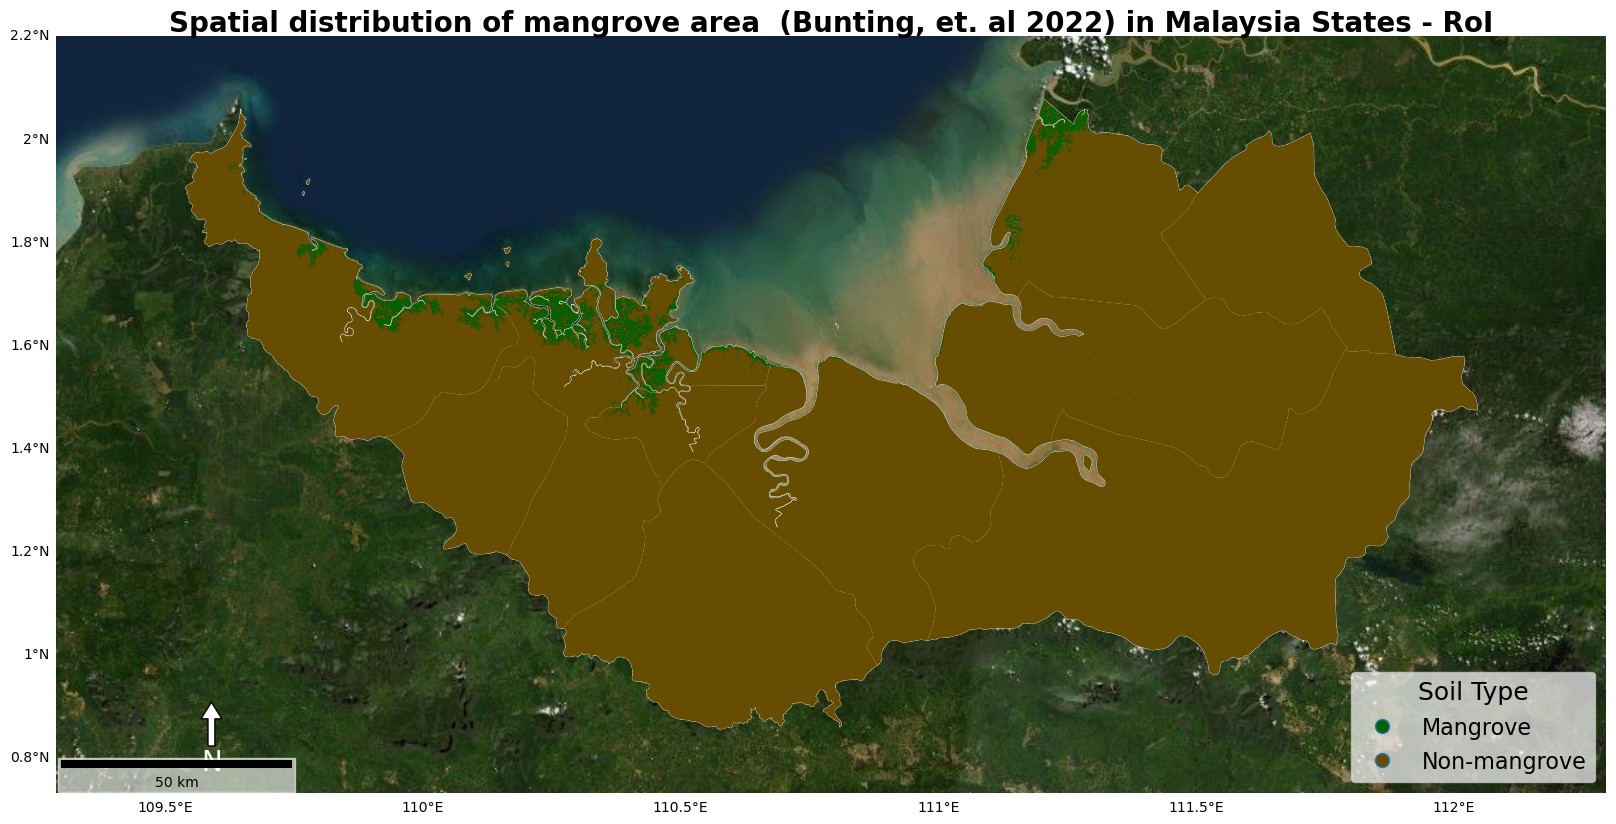

In [17]:
# Mangrove Map
fig_mangrove = plt.figure(figsize=(30,30), facecolor = 'white', frameon=True)
ax_mangrove = gplt.webmap(df=roi_proj_4326, projection=gcrs.WebMercator(),
                          provider=ctx.providers.Esri.WorldImagery, figsize=(20,20))
ax_mangrove = gplt.polyplot(roi_proj_4326, projection = gcrs.WebMercator(), **roi_kwargs, ax = ax_mangrove)
#ax_mangrove = gplt.polyplot(mangrove_roi_proj_4326, projection = gcrs.WebMercator(), **mangrove_kwargs, ax = ax_mangrove)

#ax_mangrove = gplt.polyplot(mangrove_nonmangrove_roi_proj_4326, projection = gcrs.WebMercator(), ax = ax_mangrove)
ax_mangrove = gplt.choropleth(mangrove_nonmangrove_roi_proj_4326, hue='Data', projection=gcrs.WebMercator(), 
                              edgecolor = None, linewidth = 0.5, cmap=colormap,
                              legend=True, ax = ax_mangrove,
                              legend_kwargs={'frameon': True, 'framealpha' : 0.7, 'loc': 'lower right', 'fontsize' : 16, 'title':'Soil Type', 'title_fontsize' : 18},
                              legend_labels=['Mangrove', 'Non-mangrove'],
                              scheme = scheme_mnm
                             )

x, y, arrow_length = 0.1, 0.12, 0.08
ax_mangrove.annotate('N', color='white', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='white', width=5, headwidth=15),
                     ha='center', va='center', fontsize=20,
                     xycoords=ax_mangrove.transAxes)

ax_mangrove.add_artist(ScaleBar(1, box_alpha=0.6, location = 'lower left'))
ax_mangrove = ax_mangrove.gridlines(visible = None, draw_labels=True, dms=False, x_inline=False, y_inline=False)
ax_mangrove.top_labels=False
ax_mangrove.right_labels = False
plt.title("Spatial distribution of mangrove area  (Bunting, et. al 2022) in " +  projectname + " - RoI", va = 'center_baseline', fontsize=20, fontweight="bold")
plt.savefig(os.path.join(out_dir, projectname + '_MangroveDistribution_Map.png'), bbox_inches='tight', 
            facecolor=fig_mangrove.get_facecolor())

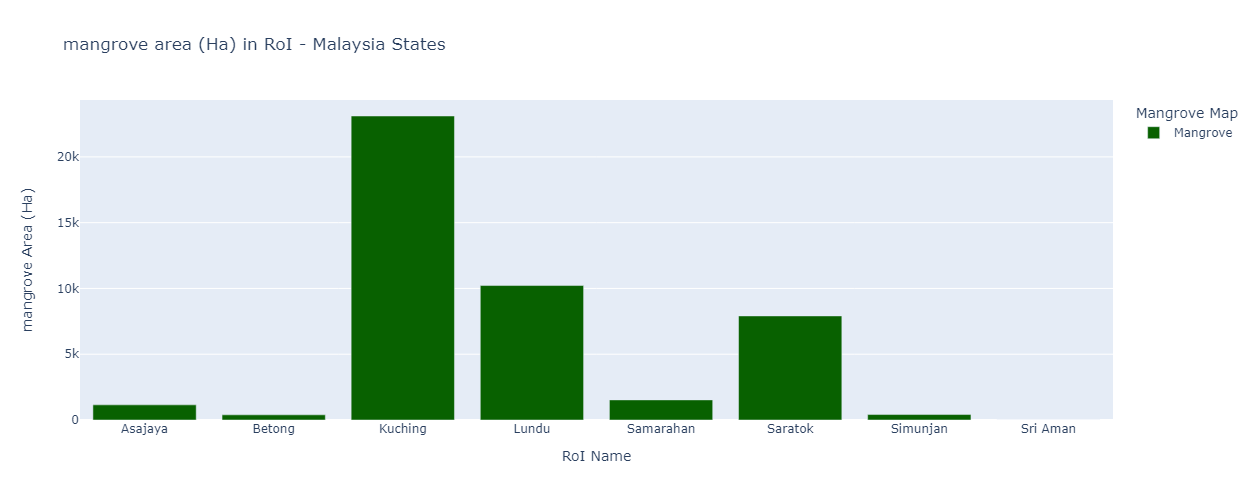

In [18]:
mangrove_nonmangrove_roi_proj_filtered = mangrove_nonmangrove_roi_proj.loc[mangrove_nonmangrove_roi_proj['Data'] == 1]

# Mangrove area in RoI
fig_mangrovearea = px.bar(mangrove_nonmangrove_roi_proj_filtered, x = mangrove_nonmangrove_roi_proj_filtered[roi_column_name],
                      y =mangrove_nonmangrove_roi_proj_filtered.Area_Ha, color = 'Data_cat',
                      category_orders={"mangrove Map": ["Mangrove"]},
                      color_discrete_sequence = ['#086100'],
                      width=1400, height=500, 
                      labels = {roi_column_name: "RoI Name","Area_Ha": "mangrove Area (Ha)"},
                      title ="mangrove area (Ha) in RoI - " + projectname)
fig_mangrovearea.update_layout(legend_title_text='Mangrove Map')

### Export Data

In [23]:
# 1. MangroveArea csv
mangrove_nonmangrove_roi_proj_df = pd.DataFrame(mangrove_nonmangrove_roi_proj).fillna(0)
mangrove_nonmangrove_roi_proj_df = mangrove_nonmangrove_roi_proj_df.drop('geometry', axis =1 )
mangrove_nonmangrove_roi_proj_df.to_csv(os.path.join(out_dir, projectname + '_RoI_MangroveArea.csv'))

# 2. peat and non-peat shapefile
mangrove_nonmangrove_roi_proj.to_file(os.path.join(out_dir, projectname + 'MangroveNonMangrove.shp'))

# 3. Peat Area Graph
fig_mangrovearea.write_image(os.path.join(out_dir, projectname + '_RoI_MangroveArea_Graph.png'))

### Processing Check

In [24]:
if 'Mangrove' in mangrove_nonmangrove_roi_proj['Data_cat'].unique():
    messagebox.showinfo("Informmation", "Mangrove is found in the RoI")
else:
    messagebox.showerror("Information", "Mangrove is not found")